# Load hdf file and post-process

For a given model (as guitar_model above), set internal data using hdf5 input. Useful for post-processing only. 

Prerequisite : a complete simulation saved in hdf file (e.g. results of run.py)

### Usage: 

* call load_model function : create a model (dynamical system, interactions and so on) and load results from a previous simu from hdf file
* call post-processing tools

In [1]:
# Reload automatically all python modules before each cell exec
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import sys
import time
import os
import pickle
import numpy as np
from model_tools import load_model, load_model_nointer
# visu
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io
import h5py
import simulation_campaigns
import collections
pklfilename = 'campaign_2018.pkl'
#pkl_file = open('campaign_new_0612.pkl', 'rb')
pkl_file = open(pklfilename, 'rb')

remote_data = pickle.load(pkl_file)


for name in remote_data:
    print("Campaign name : " + name)
    if name.find('results') < 0:
        print("Available freqs:")
        print(list(remote_data[name].keys()))
        print("\n")

Campaign name : bass_2018_0.0
Available freqs:
['62720', '4014080', '2007040', '125440', '1003520', '31360', '15680', '250880', '501760', '64225280', '16056320', '8028160', '256901120', '32112640', '128450560']


Campaign name : results_paths
Campaign name : bass_2018_0.9
Available freqs:
['62720', '15680', '16056320', '8028160', '1003520', '125440', '2007040', '501760', '256901120', '128450560', '250880', '31360', '64225280', '32112640', '4014080']


Campaign name : bass_2018_1.0
Available freqs:
['8028160', '250880', '1003520', '15680', '125440', '64225280', '501760', '128450560', '2007040', '4014080', '32112640', '31360', '62720', '256901120', '16056320']


Campaign name : fretless_2018_0.0
Available freqs:
['15680', '62720', '31360', '250880', '1003520', '125440', '16056320', '501760', '2007040', '4014080', '8028160', '64225280', '32112640']


Campaign name : fretless_2018_0.9
Available freqs:
['1003520', '125440', '250880', '16056320', '32112640', '62720', '15680', '8028160', '313

## Select input file(s) and load model(s)

In [5]:
def load(filename):
    if filename.find('bass') >= 0:
        matlab_input = './bass_guitar/pb2'
    elif filename.find('fretless') >= 0:
        matlab_input = './fretless_bass_guitar/bsf'
    elif filename.find('single') >=0 :
        matlab_input = './one_contact/pb1'
    else:
        matlab_input = './bass_guitar/pb2'
    m, s, f, e = load_model(filename)
    frets_file = matlab_input + '_h.mat'
    all_frets_positions = scipy.io.loadmat(frets_file)['h'][:, 0]
    print(m.modal_values)
    #if filename.find('converted') >= 0:
    #    m._convert[...]=False
    #    h5source = h5py.File(filename, 'r')
    #    restit = h5source.attrs['restit']
    #    h5source.close()
    #else:
    #    m.convert_modal_output(s)
    #    restit = None
    return m, s, f, all_frets_positions, e#, restit

In [6]:
camp = 'bass_22012018'
names = [name for name in remote_data.keys() if name.find(camp) >=0]
allfiles = {}
for index in range(len(names)):
    campaign = remote_data[names[index]]
    results_path = remote_data["results_paths"][1]
    fileslist = {}
    for freq in campaign:
        fileslist[np.float(freq)] = os.path.join(results_path, campaign[freq][5])
    fileslist = collections.OrderedDict(sorted(fileslist.items()))
    print(names[index])
    print('select one of the available freqs:')
    for freq in fileslist:
        print(freq)
        #print(fileslist[freq])
    allfiles[names[index]] = fileslist



bass_22012018_0.0
select one of the available freqs:
2048000.0
bass_22012018_1.0
select one of the available freqs:
4096000.0


./results_bass_2018/F_1003520_id_4075770/converted_bass_e1.0_862_1003520.h5
./tmp
Load model from file ./results_bass_2018/F_1003520_id_4075770/converted_bass_e1.0_862_1003520.h5


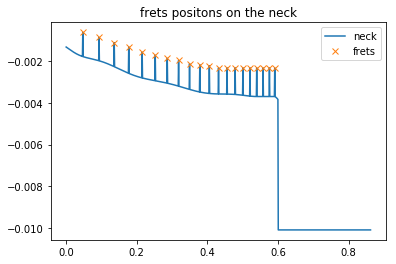

In [4]:

freqref = 4096000.0
#freqref = 2048000.0
#freqref2 = 4096000.0
#f1 = allfiles['bass_22012018_1.0'][freqref]
f1 = './results_bass_2018/F_1003520_id_4075770/converted_bass_e1.0_862_1003520.h5'
print(f1)
#f2 = allfiles['bass_full_012018_1.0'][freqref2]
#f3 = allfiles['bass_full_2018_1.0'][freqref]
#f2 = './/results_bass_2018/F_2048000_id_4902276/converted_bass_e0.0_862_2048000.h5'
#f3 = './/results_bass_2018/F_2048000_id_4955029/converted_bass_e0.0_862_2048000.h5'
fig_path = './tmp'#fig_campaign_2018/bass/last'
print(fig_path)
# Full : ie all ts
#reference_file = './results_bass_1812/F_4014080_id_4074866/converted_bass_e0.0_862_4014080.h5'
#f1=f2
#
#reference_file = './results_bass_1812/F_4014080_id_4074829/converted_bass_e0.0_862_4014080.h5'
#reference_file = '/Users/Franck/Projets/Siconos/myfork/siconos/examples/Mechanics/Music/bass_e0.0_862_100680.h5'
#f1 = f3

#f1 = './tmp_noc.h5'#./results_bass_2018/F_62720_id_4075728/converted_bass_e0.0_862_62720.h5'
#f2 = './tmp.h5'
m1, s1, fr1, e1 = load_model(f1)
#m2, s2, fr2, fp2, e2 = load(f2)
#m3, s3, fr3, fp3, e3 = load(f3)
    
if not os.path.exists(fig_path):
    os.mkdir(fig_path)



    

In [ ]:
m1, s1, f1, r1 = load_model(f1)

In [ ]:
m1.interactions_output

## Plot trajectories
Use plotTraj(dynamical_system, list of dof to be plotted)

If list of dof is not set, all dof will be plotted.

Result = dof as a function of time +  zoom specific ranges (as in the paper)

To save the resulting figure(s), add argument filename when calling plotTraj

Arg 'iplot' is used to change figure number. Set same iplot if you want to plot all curves on the same figure.
Default iplot=0.

In [ ]:
inter = fr1[0]
inter.contact_index

In [ ]:
m1.time_step

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

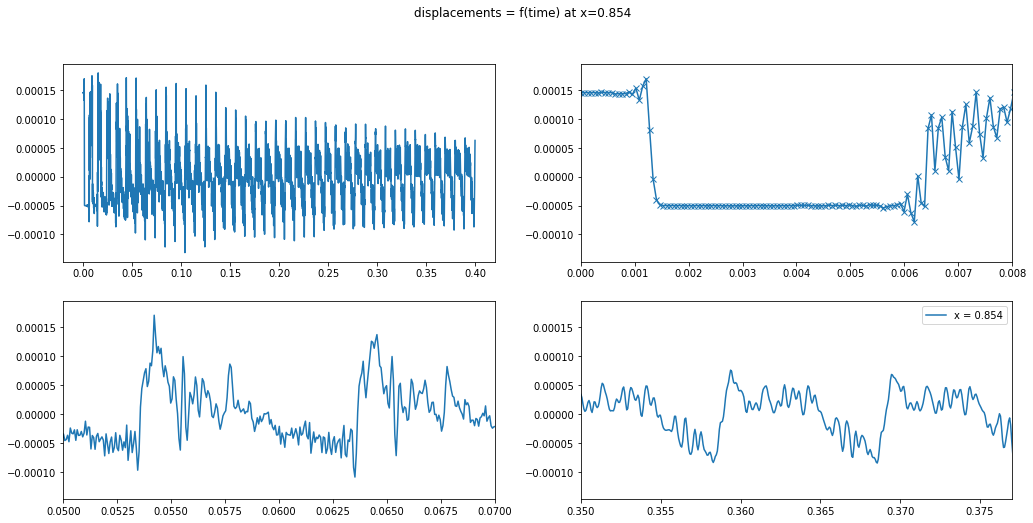

In [5]:
# Select dof to plot traj
dof = 853
#ground = fp1[dof]#- guitar_string.diameter*0.5
#print(ground)
freq = m1.fs
filename = os.path.join(fig_path, 'full_traj_' + str(freq) + '_x=' + str(dof) + '.pdf')
m1.plot_traj(s1, dof=dof, iplot=0,filename=filename)#, ground=ground)#
#current_model.plot_traj(current_string, dof=dof, iplot=0)#, filename=filename)
#m3.plot_traj(s3, dof=dof, iplot=0)#, filename=filename)


#dof = 9
#ground = frets_pos[dof]#- guitar_string.diameter*0.5
#filename = os.path.join(fig_path, 'traj_' + str(freq) + '_x=' + str(dof) + '.pdf')
#guitar_model.plot_traj(guitar_string, dof=dof, iplot=1, filename=filename)#, ground=ground)
#guitar_model2.plot_traj(guitar_string2, dof=dof, iplot=0, )#, ground=ground

In [ ]:
dof = 853
traj1 = m1.data_ds[s1][dof,:]
traj2 = m2.data_ds[s2][dof,:]
#traj3 = m3.data_ds[s3][dof,:]
t1 = m1.time
t2 = m2.time
#t3 = m3.time
plt.figure(figsize=(17, 8))
plt.plot(t1, traj1, '--',t2, traj2, ':' )#, t3, traj3, '--x')
plt.xlim(0, 0.08)
#plt.xlim(0.8, 1)
leg = ['e=0.', 'e=0.9', 'e=1.']
plt.legend(leg)
plt.xlabel('time')
plt.title('displacement at x='+str(s1.x[dof]) + 'for fe = '+ str(freq) + ' Hz' )
filename = os.path.join(fig_path, 'comp_traj_' + str(freq) + '_x=' + str(dof) + '.pdf')
plt.savefig(filename)

In [ ]:
traj2.shape

In [ ]:
np.allclose(traj1, traj2)

In [ ]:
inter = m1.data_interactions
m1.save_interactions

In [ ]:
ic = 0
time = guitar_model.time
y = inter[guitar_frets[ic]][0][:]
#ydot = inter[frets[ic]][:,1]
plt.figure()
for ic in range(len(guitar_frets)):
    lamb = inter[guitar_frets[ic]][1][:]
    #print(np.where(lamb >=1e-22))
    plt.plot(time, lamb, 'o')


    
#plt.plot(time, ydot,'--x')
plt.xlim(0,0.05)
#plt.ylim(-10,10)
ind = np.where(y<0)
ind2 = np.where(y>=0)

plt.figure(44)
#plt.clf()
plt.plot(time[ind2], y[ind2], 'k:o', time[ind], y[ind], 'rx:', )
plt.xlim(0.003, 0.009)
#plt.figure()

#plt.plot(time, lamb, 'k:o')
                               

In [14]:
dofs = {}
datas = m1.data_ds[s1][:,:]
dofs['alldofs'] = datas
dofs['time'] = m1.time


In [15]:
fig_path

'./tmp'

In [16]:
import scipy.io as sio
filename = os.path.join(fig_path, 'new_initial_cond_alldofs_e=1.mat')
print(filename)

./tmp/new_initial_cond_alldofs_e=1.mat


In [17]:
sio.savemat(filename, dofs)

# Plot modes

Use guitar_model.plot_modes(guitar_string,plot_shape)

plot_shape = (x,y) where x,y is the resolution of the grid of plots.

Example: 
plot_modes(guitar_string, (4,2)) : splits time range in 8 and plots dof=f(x) for those 8 time instants on 8 figures


Set filename arg to save resulting figure in a file.

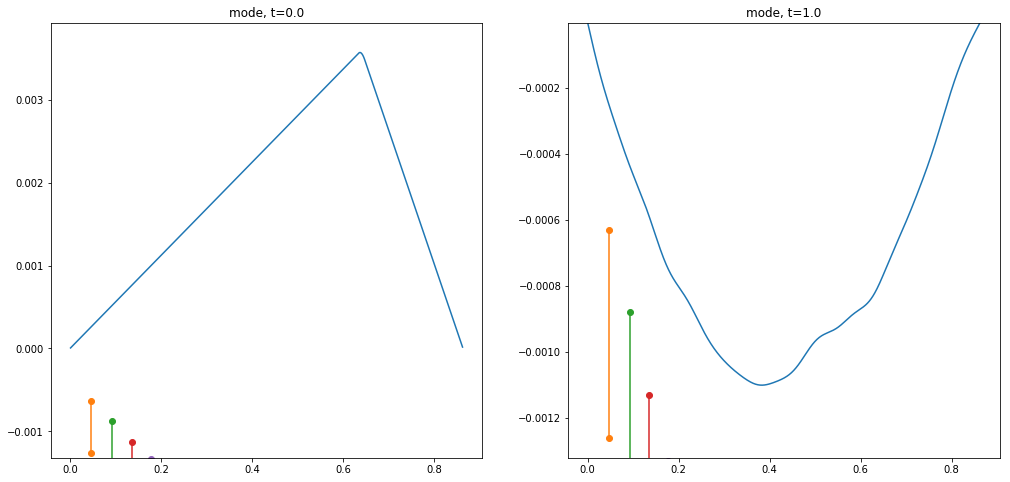

In [8]:
# Plot 10 figures on two columns, for 10 time instants
m1.plot_modes(s1,plot_shape=[1,2], iplot=0)
plt.savefig(os.path.join(fig_path, 'modes.pdf'))
# Same thing but save output in modes.pdf
#guitar_model.plot_modes(guitar_string,plot_shape=[5,3], filename='modes.pdf', iplot=1)
# plot modes for time[12] and time[5000] on one column
#guitar_model.plot_modes(guitar_string, times =[12, 1200], plot_shape=(2,1), filename='modes2.pdf', iplot=2)

In [ ]:
newq = m1.data_ds[s1][:,0]
plt.plot(s1.x, newq)
plt.xlim(0.45,0.75)

## Plot contactogram

    !! Works only if enable_interactions_output=True in model (guitar_model) constructor

In [ ]:
print(fig_path)

In [ ]:
m1.contactogram(s1, 33)
#plt.xlim(0.0035, 0.0045)
plt.savefig(os.path.join(fig_path, 'contacto.pdf'))
m1.nb_time_steps_output

## Create a movie mode=f(time)

In [ ]:
moviename = os.path.basename(f1)
moviename = os.path.join(fig_path, os.path.splitext(moviename)[0] + '.mp4')
print(moviename)
#moviename = 'tmp.mp4'
m1.make_movie(s1, moviename, sampling=10)

In [ ]:
if os.path.exists(('./last.mp4')):
    os.remove('./last.mp4')
os.symlink(moviename, 'last.mp4')

<video controls src="last.mp4" />
#%%html
#<video width="320" height="240" controls>
#  <source src="./last.mp4" type="video/mp4">
#</video>

In [ ]:
import scipy.io as sio

In [ ]:
ref = sio.loadmat('false_h.mat')


In [ ]:
ref['h'].shape

In [ ]:
sio.savemat('false_h.mat', ref)